In [2]:
import numpy as np
from xml.etree import ElementTree
import cv2
from PIL import Image
import tensorflow as tf
import csv
import argparse
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [3]:
save_path = '/home/ubuntu/Sayama/tmpdir/2020_08_04/video1top_png/image_02/data/'


In [4]:
file_names=["frame_000250.png"]
#for file in os.listdir(save_path):
    # Getting File Names
    #if os.path.isfile(os.path.join(save_path, file)):
        #file_names.append(os.path.basename(file))

In [5]:
def draw_images(image_file):
    
    global save_path
    
    f_name=save_path+"/"+image_file
    gray_img=cv2.imread(f_name)
   

    
    
    return gray_img



frame_000250.png


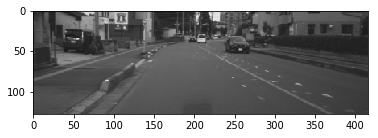

In [6]:
#Showing img
for number, image in enumerate(file_names[0:1]):
    print(image)
    gray_img = draw_images(image)
    plt.axis('on')
    plt.imshow(cv2.cvtColor(gray_img, cv2.COLOR_BGR2RGB))


In [7]:
file_names_2 = ["frame_000250"]
#for file in os.listdir(save_path):
    #if os.path.isfile(os.path.join(save_path, file)):
        #file2 = file.rstrip('.png\n')
        #file_names_2.append(file2)

In [8]:
depth_map_dir="/home/ubuntu/Sayama/result_video1top_1000977/"

i=0

pred_depth=np.load(depth_map_dir+file_names_2[i] +'.npy')

In [9]:
pred_depth

array([[[0.94879544],
        [0.9578726 ],
        [0.9819195 ],
        ...,
        [1.8554149 ],
        [1.85335   ],
        [1.8425026 ]],

       [[0.95480824],
        [0.96122336],
        [0.97668505],
        ...,
        [1.8589401 ],
        [1.8405148 ],
        [1.8502903 ]],

       [[0.96187806],
        [0.9651274 ],
        [0.9766757 ],
        ...,
        [1.8519522 ],
        [1.839597  ],
        [1.8355111 ]],

       ...,

       [[0.46992683],
        [0.48068088],
        [0.4788524 ],
        ...,
        [0.5442344 ],
        [0.5292213 ],
        [0.52936155]],

       [[0.45398217],
        [0.45675096],
        [0.4666919 ],
        ...,
        [0.53105474],
        [0.52072096],
        [0.51843315]],

       [[0.45040035],
        [0.44374543],
        [0.45727617],
        ...,
        [0.51442075],
        [0.4920099 ],
        [0.5003514 ]]], dtype=float32)

In [10]:
pred_depth.size

53248

In [11]:
pred_depth = cv2.resize(pred_depth, (416,128))

In [12]:
pred_depth

array([[0.94879544, 0.9578726 , 0.9819195 , ..., 1.8554149 , 1.85335   ,
        1.8425026 ],
       [0.95480824, 0.96122336, 0.97668505, ..., 1.8589401 , 1.8405148 ,
        1.8502903 ],
       [0.96187806, 0.9651274 , 0.9766757 , ..., 1.8519522 , 1.839597  ,
        1.8355111 ],
       ...,
       [0.46992683, 0.48068088, 0.4788524 , ..., 0.5442344 , 0.5292213 ,
        0.52936155],
       [0.45398217, 0.45675096, 0.4666919 , ..., 0.53105474, 0.52072096,
        0.51843315],
       [0.45040035, 0.44374543, 0.45727617, ..., 0.51442075, 0.4920099 ,
        0.5003514 ]], dtype=float32)

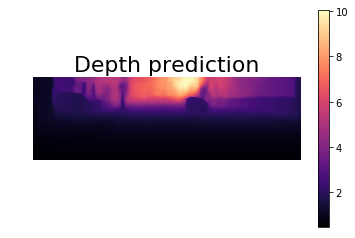

In [13]:
plt.imshow(pred_depth, cmap='magma')
plt.title("Depth prediction", fontsize=22)
plt.axis('off')
plt.colorbar()

# ここからが新規パート

In [14]:
# Abs Rel Error計算用パラメタ
min_depth=10
max_depth=20
bf=109.65
d_inf=2.67

## 深度正解画像の位置

In [15]:
ans_int_disp_map_dir="/home/ubuntu/Sayama/tmpdir/2020_08_04/video1middle_png/image_02/data"

In [16]:
def draw_images_ans_int(image_file):
    
    global ans_int_disp_map_dir
    
    f_name=ans_int_disp_map_dir+"/"+image_file
    ans_int_disp_map=cv2.imread(f_name)
    ans_int_disp_map=cv2.cvtColor(ans_int_disp_map, cv2.COLOR_RGB2GRAY)
   

    
    
    return ans_int_disp_map



frame_000250.png


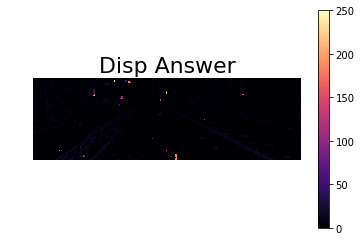

In [17]:
for number, image in enumerate(file_names[0:1]):
    print(image)
    ans_int_disp_map = draw_images_ans_int(image)
    #plt.figure(dpi=50)
    plt.imshow(ans_int_disp_map, cmap='magma')
    plt.title("Disp Answer", fontsize=22)
    plt.axis('off')
    plt.colorbar()

In [18]:
np.set_printoptions(np.inf)

In [19]:
print(ans_int_disp_map)

[[ 0  0  0 ...  4  0  0]
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  3  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [18  0  0 ...  0  0  0]]


In [20]:
gt_depth=bf/(ans_int_disp_map-d_inf)

In [21]:
mask = np.logical_and(gt_depth>min_depth,gt_depth <max_depth)

In [22]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [23]:
#gt_depth=gt_depth*mask

In [24]:
#plt.imshow(gt_depth, cmap='magma')
#plt.title("Depth Answer", fontsize=22)
#plt.axis('off')
#plt.colorbar()

In [25]:
#gt_depth[mask]

In [26]:
#pred_depth[mask]

In [27]:
scalor = np.median(gt_depth[mask])/np.median(pred_depth[mask])

In [28]:
print(scalor)

14.341892463548573


In [29]:
pred_depth[mask] *= scalor

In [30]:
pred_depth[pred_depth < min_depth] = min_depth
pred_depth[pred_depth > max_depth] = max_depth

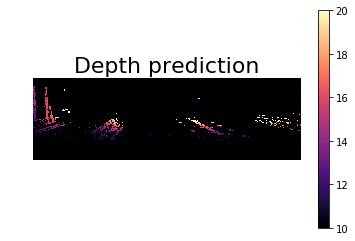

In [31]:
plt.imshow(pred_depth, cmap='magma')
plt.title("Depth prediction", fontsize=22)
plt.axis('off')
plt.colorbar()

In [32]:
def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25   ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)
    
    sq_rel = np.mean(((gt - pred)**2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

In [33]:
num_test=1
i=0

In [34]:
rms     = np.zeros(num_test, np.float32)
log_rms = np.zeros(num_test, np.float32)
abs_rel = np.zeros(num_test, np.float32)
sq_rel  = np.zeros(num_test, np.float32)
d1_all  = np.zeros(num_test, np.float32)
a1      = np.zeros(num_test, np.float32)
a2      = np.zeros(num_test, np.float32)
a3      = np.zeros(num_test, np.float32)
scalors = np.zeros(num_test, np.float32)

In [35]:
abs_rel[i], sq_rel[i], rms[i], log_rms[i], a1[i], a2[i], a3[i] = \
            compute_errors(gt_depth[mask], pred_depth[mask])

print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10} ".format('abs_rel', 'sq_rel', 'rms', 'log_rms', 'd1_all', 'a1', 'a2', 'a3', 'scalor'))
print("{:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f} ,{:10.4f} ".format(abs_rel.mean(), sq_rel.mean(), rms.mean(), log_rms.mean(), d1_all.mean(), a1.mean(), a2.mean(), a3.mean(),scalors.mean()))


   abs_rel,     sq_rel,        rms,    log_rms,     d1_all,         a1,         a2,         a3,     scalor 
    0.1239,     0.3358,     2.1989,     0.1453,     0.0000,     0.8992,     0.9948,     1.0000 ,    0.0000 


In [36]:
#条件同じにして比較することを重視すると良い

# Make Mask

In [44]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from xml.etree import ElementTree
from xml.dom import minidom
import collections
import matplotlib as matplot
import seaborn as sns
import cv2
import shutil
from absl import app
from absl import flags
from absl import logging
import glob
import alignment
from alignment import compute_overlap
from alignment import align

In [48]:
#video_path
base_path = save_path
# Root directory of the RCNN project
ROOT_DIR = os.path.abspath("../Mask_RCNN")
# result WIDTH and HEIGHT
WIDTH = 416
HEIGHT = 128
# calib_cam_to_cam.txt path
INPUT_TXT_FILE="./calib_cam_to_cam.txt"
# result seq length
SEQ_LENGTH = 3
# result step size
STEPSIZE = 1
#result output dir
OUTPUT_DIR = '../out'
#temp data dir
TEMP_DIR="../tmp"

In [49]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 
#delete this line in py file

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [50]:
data_dirs=[f.name for f in os.scandir(base_path) if not f.name.startswith('.')]

In [52]:
#data_dirs

In [53]:
#これでは不可

## Scale matching

In [36]:

import math
height=1.2
theta=85
theta=theta*math.pi/180

In [37]:
truth_z=height/math.cos(theta)

In [38]:
truth_z

13.76845589480383

In [39]:
def calc_center(xmin=0,ymin=0,img_height=128,img_width=416,clip_height=128,clip_width=416,dfv_height=128,dfv_width=416):
    #xとyが逆かも
    #後で実装
    center_ratio_x=(img_height//2-xmin)/clip_height
    center_ratio_y=(img_width//2-ymin)/clip_width
    center_x=int(dfv_height*center_ratio_x)
    center_y=int(dfv_width*center_ratio_y)
    return [center_x,center_y]

In [40]:
center=calc_center()

In [41]:
print(center[0])
print(center[1])

64
208


In [42]:
prezent_z=pred_depth[center[0]][center[1]]
#これだとうまくいかない

In [43]:
prezent_z

10.0

In [44]:
#y_top=trapezoid[4]
#y_bottom=trapezoid[5]

In [45]:
#trapezoid_center=int((trapezoid[4]+trapezoid[5])/2)
#trapezoid_center=trapezoid[5]
#trapezoid_center=104

In [46]:
#trapezoid_center

In [47]:
#prezent_z=depth_map[trapezoid_center][216]
#これだとうまくいく
